In [1]:
import sys, os
import serial
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import win32com.client
from astropy.io import fits
import threading
import nbimporter
from picoammeter_control import (
    send_cmd,
    query,
    init_cmds
)
from camera_control_ascom import (
    take_ramp,
    camera_init,
    populate_header
)
sys.path.insert(0, os.path.abspath('.'))
sys.path.insert(0, os.path.abspath('filter_wheel_control'))
from filter_wheel_control.wheel_controller import (
    list_devices,
    open_device,
    get_position,
    get_position_count,
    set_position,
    close_device
)
from data_helper_functions import (
    init_wheels,
    close_wheels,
    camera_init,
    picoam_stability,
    picoam_worker_exp,
    camera_with_picoam,
    collect_var_exp,
    var_exp_graphs,
    capture_frame,
    calculate_gain,
    get_gain,
    picoam_worker_filters,
    camera_with_filters,
    collect_var_filters,
    compare_exp_and_filter,
    collect_bias_frames
)

In [2]:
camera_init()
cam_name = "ASCOM.AtikCameras.Camera"
save_path= "C:/Users/Jonah/fits_imgs"

You selected: ASCOM.AtikCameras.Camera


In [3]:
min_exp = 0.001
max_exp = 5.0

In [4]:
init_wheels(print_stuff=False)
close_wheels()

In [ ]:
e_per_adu = get_gain(cam_name=cam_name, exp_time=min_exp, num_frames=5, print_stuff=True)


Camera connected: ASCOM.AtikCameras.Camera, Size: 9576x6380, Temperature: 24.90C
Taking frames at 0.00100000 seconds (exposure time 1/30)
Taking frames at 0.00136329 seconds (exposure time 2/30)
Taking frames at 0.00185857 seconds (exposure time 3/30)
Taking frames at 0.00253377 seconds (exposure time 4/30)
Taking frames at 0.00345428 seconds (exposure time 5/30)
Taking frames at 0.00470919 seconds (exposure time 6/30)
Taking frames at 0.00642001 seconds (exposure time 7/30)
Taking frames at 0.00875236 seconds (exposure time 8/30)
Taking frames at 0.01193203 seconds (exposure time 9/30)
Taking frames at 0.01626686 seconds (exposure time 10/30)
Taking frames at 0.02217650 seconds (exposure time 11/30)
Taking frames at 0.03023308 seconds (exposure time 12/30)
Taking frames at 0.04121656 seconds (exposure time 13/30)
Taking frames at 0.05619026 seconds (exposure time 14/30)
Taking frames at 0.07660380 seconds (exposure time 15/30)
Taking frames at 0.10443346 seconds (exposure time 16/30)

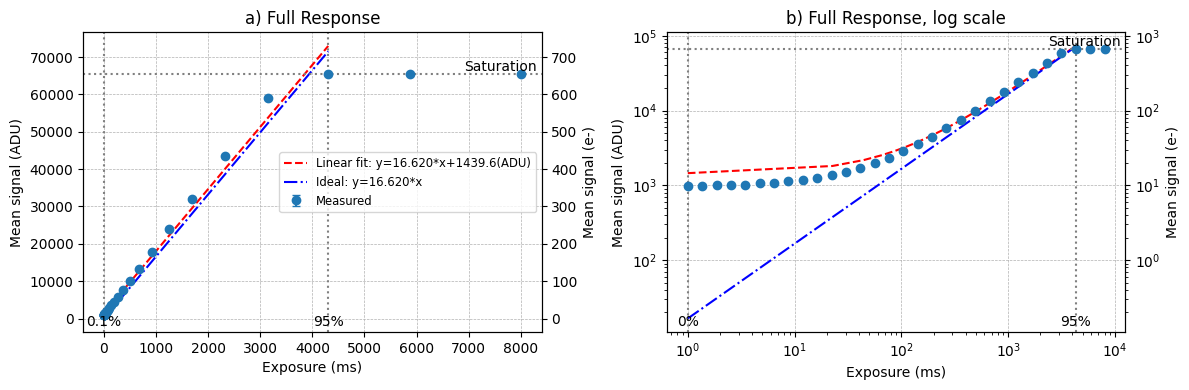

Figure saved to exp_0.001-8.0_linearity_figure.png


In [5]:
I_flat, Q_ramp, mean_signal, std_signal, bit_depth, exp_times, exp_low, exp_high, exp_50 = (
    collect_var_exp(cam_name=cam_name, num_exp=30, num_frames=3, exp_low = min_exp, exp_high = max_exp, save_path=save_path, offset=0)
)

var_exp_graphs(mean_signal, std_signal, bit_depth, exp_times, exp_low, exp_high, save=True, e_per_adu=.01, min_percent=0.001, percent_change=False)

In [6]:
signals_f, Q_filt = collect_var_filters(save_path = save_path, cam_name=cam_name, exp_50=exp_50, num_frames=5, offset=0)


starting filter 1
starting filter 2
starting filter 3
starting filter 4
starting filter 5
starting filter 6
Wrote per-frame filter data to C:/Users/Jonah/fits_imgs\filter_frame_data.csv
finished


In [7]:
bias_level = collect_bias_frames(cam_name = cam_name,num_frames=5, exp_low=min_exp, save_path=save_path, offset=0)
print("bias level: ", bias_level)

Camera connected: ASCOM.AtikCameras.Camera, Size: 9576x6380, Temperature: 25.93C
Taking frames at 0.00100000 seconds (exposure time 1/1)
exp res: 0.00100000 seconds
Bias cube saved to C:/Users/Jonah/fits_imgs\bias_stack.fits
Bias means saved to C:/Users/Jonah/fits_imgs\bias_means.csv
bias level:  972.8682709999999


972.8682709999999
Figure saved to exp_vs_filter_figure.png


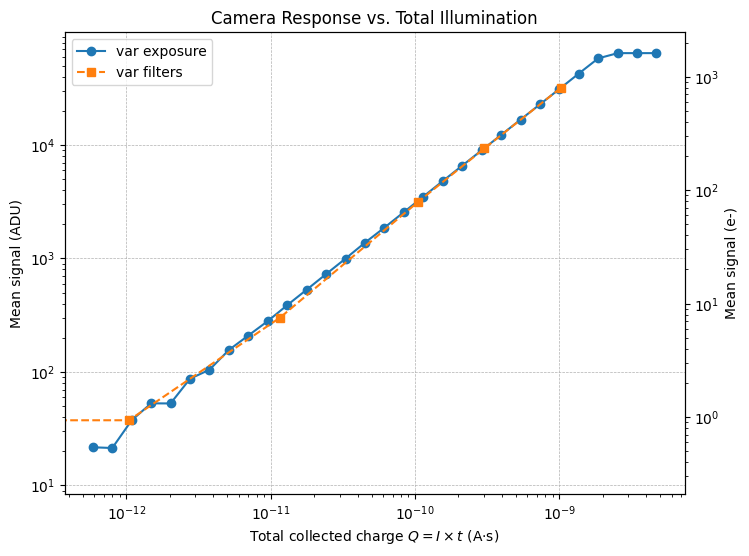

In [8]:
compare_exp_and_filter(e_per_adu = .025, Q_ramp=Q_ramp, Q_filt=Q_filt, signals_f=signals_f, mean_signal=mean_signal, bias_level=bias_level, save=True)
